In [79]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tf_models.FFNNRegressorModel import FFNNRegressor
from scripts.feature_engineering import season_start_year
from typing import List, Tuple, Optional
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Let's add helpers for Data Cleaning

In [46]:
def drop_columns_save_interim(
    df: pd.DataFrame,
    cols_to_drop: list = None,
    filename: str = "dataset",
    output_subdir: str = "interim",
) -> pd.DataFrame:
    """
    Drops specified columns from a DataFrame.
    Saves the cleaned DataFrame in ../data/interim relative to this script.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    cols_to_drop : list, optional
        Columns to Drop, by default None
    filename : str, optional
        Base name for saved CSV files (default is 'dataset').
    output_subdir : str, optional
        Subdirectory inside /data (default is 'interim').

    Returns
    -------
    pd.DataFrame
        The cleaned DataFrame with specified columns removed.
    """

    # Determine absolute path: ../data/interim relative to this script
    script_dir = os.path.dirname(os.getcwd())
    data_dir = os.path.abspath(os.path.join(script_dir, "..", "data", output_subdir))

    # Ensure directories exist
    os.makedirs(data_dir, exist_ok=True)

    # Drop them from the main DataFrame
    df_reduced = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    # Build save paths
    cleaned_path = os.path.join(data_dir, f"{filename}_post_drop.csv")

    # Save both files
    df_reduced.to_csv(cleaned_path, index=False)

    print(f"Cleaned file saved to: {cleaned_path}")

    return df_reduced

def normalize_position_column(
    df: pd.DataFrame,
    column: str = "position",
    filename: str = "dataset",
    output_subdir: str = "interim",
) -> pd.DataFrame:
    """
    Normalizes position values — e.g., replaces 'GKP' with 'GK' — and saves the cleaned dataset.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    column : str, optional
        The column to normalize (default is 'position').
    filename : str, optional
        Base name for saved file (default is 'dataset').
    output_subdir : str, optional
        Subdirectory under /data to save (default is 'interim').

    Returns
    -------
    pd.DataFrame
        Updated DataFrame with normalized position values.
    """

    # Determine save path (../data/interim)
    script_dir = os.path.dirname(os.path.abspath(os.getcwd()))
    data_dir = os.path.abspath(os.path.join(script_dir, "..", "data", output_subdir))
    os.makedirs(data_dir, exist_ok=True)

    df = df.copy()
    df[column] = df[column].apply(lambda x: "GK" if x == "GKP" else x)

    # Save cleaned file
    cleaned_path = os.path.join(data_dir, f"{filename}_normalized.csv")
    df.to_csv(cleaned_path, index=False)

    return df


Let's add helpers to help us in feature engineering.

In [47]:
def one_hot_encode_columns(
    df: pd.DataFrame,
    columns_to_encode: list,
    filename: str = "dataset",
    output_subdir: str = "interim",
    drop_first: bool = True,
) -> pd.DataFrame:
    """
    One-hot encodes specified categorical columns in the given DataFrame.
    Saves both the encoded DataFrame and a record of encoded column names.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing categorical columns.
    columns_to_encode : list
        List of column names to one-hot encode.
    filename : str, optional
        Base name for saved CSVs (default is 'dataset').
    output_subdir : str, optional
        Folder under /data where outputs will be saved (default is 'interim').
    drop_first : bool, optional
        Whether to drop the first level of each encoded variable
        (useful for regression models to avoid dummy-variable trap).

    Returns
    -------
    pd.DataFrame
        The transformed DataFrame with one-hot encoded columns.
    """

    # --- Setup directories ---
    root_data_dir = os.path.join(os.getcwd(), "data")
    output_folder = os.path.join(root_data_dir, output_subdir)
    os.makedirs(output_folder, exist_ok=True)

    # --- One-hot encode ---
    encoded_df = pd.get_dummies(df, columns=columns_to_encode, drop_first=drop_first)

    # --- Save outputs ---
    encoded_path = os.path.join(output_folder, f"{filename}_encoded.csv")

    encoded_df.to_csv(encoded_path, index=False)

    return encoded_df



def label_encode_column(
    df: pd.DataFrame,
    column: str,
    filename: str = "dataset",
    output_subdir: str = "interim",
) -> tuple[pd.DataFrame, LabelEncoder]:
    """
    Label-encodes a single categorical column (e.g., player names).

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    column : str
        Column name to label-encode.
    filename : str, optional
        Base name for reference/logging only (default is 'dataset').
    output_subdir : str, optional
        Folder under /data where outputs would be saved if persisted
        (kept here for signature consistency).

    Returns
    -------
    tuple[pd.DataFrame, LabelEncoder]
        - DataFrame with a new column '<column>_encoded'
        - The fitted LabelEncoder (for reverse mapping)
    """

    # Determine absolute path: ../data/interim relative to this script
    script_dir = os.path.dirname(os.path.abspath(os.getcwd()))
    data_dir = os.path.abspath(os.path.join(script_dir, "..", "data", output_subdir))

    os.makedirs(data_dir, exist_ok=True)

    le = LabelEncoder()
    df[f"{column}_encoded"] = le.fit_transform(df[column].astype(str))

    df = df.drop(columns=[column])

    print(f"Column '{column}' label-encoded → new column '{column}_encoded'")

    cleaned_path = os.path.join(data_dir, f"{filename}_label_encoded.csv")

    df.to_csv(cleaned_path, index=False)

    return df, le

def map_bool_to_int(
    df: pd.DataFrame,
    columns_to_map: list,
    filename: str = "dataset",
    output_subdir: str = "interim",
) -> pd.DataFrame:
    """
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing categorical columns.
    columns_to_map : list
        List of column names to map to int.
    filename : str, optional
        Base name for saved CSVs (default is 'dataset').
    output_subdir : str, optional
        Folder under /data where outputs will be saved (default is 'interim').

    Returns
    -------
    pd.DataFrame
        The transformed DataFrame with mapped columns.
    """

    # --- Setup directories ---
    root_data_dir = os.path.join(os.getcwd(), "data")
    output_folder = os.path.join(root_data_dir, output_subdir)
    os.makedirs(output_folder, exist_ok=True)

    # --- Map bool values to int ---
    mapped_df = df.copy()
    for col in columns_to_map:
        mapped_df[col] = mapped_df[col].map(lambda x: 1 if str(x) == "True" else 0)

    # --- Save outputs ---
    mapped_path = os.path.join(output_folder, f"{filename}_mapped.csv")

    mapped_df.to_csv(mapped_path, index=False)

    return mapped_df


def add_form(
    df: pd.DataFrame,
    filename: str = "dataset",
    output_subdir: str = "interim",
    name_column: str = "name_encoded",
) -> pd.DataFrame:
    """
    Adds 'form' for each (name, season_x) as the average of the PREVIOUS `window`
    gameweeks' total_points, divided by `divisor`, using up to `min_periods` available
    past GWs (no leakage). Saves to ../data/<output_subdir>/<filename>.csv.

    Expects columns: ['name'/'name_encoded', 'season_x', 'round', 'total_points'] exactly.
    """
    window = 4
    divisor = 10.0
    min_periods = 1
    fill_strategy = "zero"

    required = [name_column, "season_x", "round", "total_points"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    out = df.copy()
    out["round"] = pd.to_numeric(out["round"], errors="coerce")
    out = out.sort_values([name_column, "season_x", "round"])

    form = (
        out.groupby([name_column, "season_x"])["total_points"]
           .apply(lambda s: s.shift(1).rolling(window, min_periods=min_periods).mean() / divisor)
           .reset_index(level=[0, 1], drop=True)
    )

    if fill_strategy == "zero":
        form = form.fillna(0.0)

    out["form"] = form

    script_dir = os.path.dirname(os.path.abspath(os.getcwd()))
    data_dir = os.path.abspath(os.path.join(script_dir, "..", "data", output_subdir))
    os.makedirs(data_dir, exist_ok=True)

    out_path = os.path.join(data_dir, f"{filename}.csv")
    out.to_csv(out_path, index=False)
    print(f"Form-added file saved to: {out_path}")

    return out

def add_team_and_opponent_goals(
    df: pd.DataFrame,
    filename: str = "dataset",
    output_subdir: str = "interim",
) -> pd.DataFrame:
    """
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing categorical columns.
    filename : str, optional
        Base name for saved CSVs (default is 'dataset').
    output_subdir : str, optional
        Folder under /data where outputs will be saved (default is 'interim').

    Returns
    -------
    pd.DataFrame
        The transformed DataFrame with added features columns.
    """

    # --- Setup directories ---
    root_data_dir = os.path.join(os.getcwd(), "data")
    output_folder = os.path.join(root_data_dir, output_subdir)
    os.makedirs(output_folder, exist_ok=True)

    # --- Add Features ---
    df_with_features = df.copy()

    df_with_features['ally_goals'] = df_with_features.apply(
        lambda x: x['team_h_score'] if x['was_home'] == True else x['team_a_score'],
        axis=1
    )

    df_with_features['opponent_goals'] = df_with_features.apply(
        lambda x: x['team_a_score'] if x['was_home'] == True else x['team_h_score'],
        axis=1
    )

    # --- Save outputs ---
    mapped_path = os.path.join(output_folder, f"{filename}_mapped.csv")
    df_with_features.to_csv(mapped_path, index=False)

    return df_with_features

import pandas as pd
import os

def add_lag_features(
    df: pd.DataFrame,
    columns: list[str],
    lags: list[int] = [1, 2],
    filename: str = "dataset",
    output_subdir: str = "interim"
) -> pd.DataFrame:
    """
    Adds lag features (e.g., lag 1 and lag 2) for specified columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame, typically time-sorted.
    columns : list of str
        Columns to generate lag features for.
    lags : list of int, optional
        Lag steps to apply (default is [1, 2]).
    filename : str, optional
        Base name for saved CSV (default is 'dataset').
    output_subdir : str, optional
        Folder under /data where output is saved (default is 'interim').

    Returns
    -------
    pd.DataFrame
        DataFrame with new lag columns added.
    """
    # --- Setup directories ---
    root_data_dir = os.path.join(os.getcwd(), "data")
    output_folder = os.path.join(root_data_dir, output_subdir)
    os.makedirs(output_folder, exist_ok=True)

    # --- Add lag features ---
    df_with_lags = df.copy()
    for col in columns:
        if col not in df.columns:
            print(f"Skipping '{col}' — not found in DataFrame.")
            continue
        for lag in lags:
            df_with_lags[f"{col}_lag{lag}"] = df_with_lags[col].shift(lag)

    # --- Save outputs ---
    lagged_path = os.path.join(output_folder, f"{filename}_lagged.csv")
    df_with_lags.to_csv(lagged_path, index=False)

    return df_with_lags

def add_upcoming_total_points(
    df: pd.DataFrame,
    player_col: str = "name_encoded",
    season_col: str = "season_x",
    week_col: str = "round",
    points_col: str = "total_points",
) -> pd.DataFrame:
    """
    Adds a new column `upcoming_total_points` representing next week's points
    for each player-season, shifted by -1 in chronological order.
    """
    df_sorted = df.sort_values([player_col, season_col, week_col])
    df_sorted["upcoming_total_points"] = (
        df_sorted.groupby([player_col, season_col])[points_col].shift(-1)
    )
    df_sorted = df_sorted.dropna(subset=["upcoming_total_points"]).reset_index(drop=True)
    return df_sorted

def season_start_year(season_str: str) -> int:
    s = str(season_str)
    try:
        return int(s.split("-")[0])
    except Exception:
        return int(float(s))

Let's add a helper that will be used to visualize the splitting of the data

In [48]:
def summarize_round_splits(
    df: pd.DataFrame,
    train_idx: pd.Index,
    valid_idx: pd.Index,
    test_idx: pd.Index,
    season_col: str = "season_x",
    week_col: str = "round",
) -> pd.DataFrame:
    """
    For each season, list which rounds belong to TRAIN / VALID / TEST.
    Prints a compact view and returns a summary DataFrame.
    """
    df2 = df[[season_col, week_col]].copy()
    df2["_subset"] = "UNASSIGNED"
    df2.loc[train_idx.intersection(df2.index), "_subset"] = "TRAIN"
    df2.loc[valid_idx.intersection(df2.index), "_subset"] = "VALID"
    df2.loc[test_idx.intersection(df2.index),  "_subset"] = "TEST"

    # Keep only assigned rows
    df2 = df2[df2["_subset"] != "UNASSIGNED"]

    # Build per-season summary
    rows = []
    for season, g in df2.groupby(season_col, sort=True):
        out = {"season": season}
        for subset in ["TRAIN", "VALID", "TEST"]:
            rounds = sorted(g.loc[g["_subset"] == subset, week_col].unique().tolist())
            if rounds:
                rng = f"{min(rounds)}–{max(rounds)}"
                # If you also want the exact list uncomment next line:
                # out[f"{subset}_rounds_list"] = rounds
                out[f"{subset}_rounds"] = rng
                out[f"{subset}_count"] = len(rounds)
            else:
                out[f"{subset}_rounds"] = "—"
                out[f"{subset}_count"] = 0

        # Simple temporal sanity flags
        def _minmax(sub):
            r = g.loc[g["_subset"] == sub, week_col]
            return (r.min(), r.max()) if len(r) else (None, None)

        tr_min, tr_max = _minmax("TRAIN")
        va_min, va_max = _minmax("VALID")
        te_min, te_max = _minmax("TEST")

        # Check monotonic order: TRAIN ≤ VALID ≤ TEST (where present)
        ok_train_valid = (tr_max is None or va_min is None) or (tr_max <= va_min)
        ok_valid_test  = (va_max is None or te_min is None) or (va_max <= te_min)
        out["order_ok"] = bool(ok_train_valid and ok_valid_test)

        rows.append(out)

    summary = pd.DataFrame(rows).sort_values("season").reset_index(drop=True)

    # Pretty print
    print("\nRound allocation by season (min–max rounds per subset):")
    for _, r in summary.iterrows():
        print(
            f"  {r['season']}: "
            f"TRAIN {r['TRAIN_rounds']} ({r['TRAIN_count']}) | "
            f"VALID {r['VALID_rounds']} ({r['VALID_count']}) | "
            f"TEST {r['TEST_rounds']} ({r['TEST_count']}) "
            f"| order_ok={r['order_ok']}"
        )

    return summary

First let's import our raw data before any data cleaning or feature engineering.

In [49]:
df = pd.read_csv('../data/raw/cleaned_merged_seasons.csv', low_memory=False)

We start our Feature Engineering process by adding 2 columns, a column called 'Team Goals' and another called 'Opponent Goals', it is a way for the model to understand which team is the player's and which team is the Opponents instead of the interaction feature between was_home and home_team_goals and away_team_goals.

We will report our performance with and without it. 

Finally let's add helpers to help us in training our model.

In [50]:
def train_ffnn(
    X_train, y_train, X_valid, y_valid,
    params: Optional[dict] = None
):
    """
    Initializes and trains a feed-forward neural network for regression.
    Returns a model with a .predict(...) method for compatibility with your evaluate_model().
    """
    if params is None:
        params = {
            "hidden_units": (256, 128, 64,32),
            "dropout": 0.10,
            "l2": 1e-4,
            "lr": 1e-3,
            "epochs": 400,
            "batch_size": 1024,
            "patience": 25,
            "seed": 42,
            "verbose": 0,
        }
    model = FFNNRegressor(**params)
    model.fit(X_train, y_train, X_valid, y_valid)
    return model

def build_xy(
    df: pd.DataFrame,
    target_col: str = "upcoming_total_points",
    drop_cols: Optional[List[str]] = None,
    keep_player_id: bool = True,
    player_col: str = "name_encoded",
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separates features (X) and target (y).
    If keep_player_id=True, keeps `name_encoded` in X.
    """
    if drop_cols is None:
        drop_cols = ["season_x", "round"]

    if not keep_player_id:
        drop_cols = drop_cols + [player_col]

    feature_cols = [c for c in df.columns if c not in drop_cols + [target_col]]
    X = df[feature_cols]
    y = df[target_col]
    return X, y

def evaluate_model(
    model,
    X_test: pd.DataFrame, y_test: pd.Series,
    X_train: pd.DataFrame = None, y_train: pd.Series = None,
    X_valid: pd.DataFrame = None, y_valid: pd.Series = None,
) -> dict:
    def _metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

    report = {}

    if X_train is not None and y_train is not None:
        preds_tr = model.predict(X_train)
        report["train"] = _metrics(y_train, preds_tr)

    if X_valid is not None and y_valid is not None:
        preds_val = model.predict(X_valid)
        report["valid"] = _metrics(y_valid, preds_val)

    preds_te = model.predict(X_test)
    report["test"] = _metrics(y_test, preds_te)

    # Pretty print
    print("\n📊 Evaluation Metrics:")
    for split in ["train", "valid", "test"]:
        if split in report:
            m = report[split]
            print(f"  {split.upper()}:  MAE={m['MAE']:.4f}  RMSE={m['RMSE']:.4f}  R2={m['R2']:.4f}")

    return report

def auto_global_temporal_split_inseason(
    df: pd.DataFrame,
    season_col: str = "season_x",
    week_col: str = "round",
    train_frac: float = 0.8,
    valid_frac: float = 0.1,
    test_frac: float = 0.1,
    split_train_valid: bool = True,
    split_valid_test: bool = True,
    ratio_train_valid: float = 0.5,  # e.g., 0.5 ⇒ first half of boundary season to TRAIN, rest to VALID
    ratio_valid_test: float = 0.5,   # e.g., 0.5 ⇒ first half of boundary season to VALID, rest to TEST
) -> Tuple[pd.Index, pd.Index, pd.Index, List[int]]:
    """
    Global chronological split by season start year, with optional *within-season* (by rounds) splitting
    at the TRAIN↔VALID boundary and/or VALID↔TEST boundary.

    If TRAIN and VALID touch the same season:
        - earlier rounds (<= floor(ratio_train_valid * max_round_in_that_season)) → TRAIN
        - later  rounds  (> ...) → VALID

    If VALID and TEST touch the same season:
        - earlier rounds (<= floor(ratio_valid_test * max_round_in_that_season)) → VALID
        - later  rounds  (> ...) → TEST

    Guarantees non-empty buckets when n_seasons ≥ 3.
    """
    assert abs(train_frac + valid_frac + test_frac - 1.0) < 1e-9, "Fractions must sum to 1."

    years = sorted({season_start_year(s) for s in df[season_col].unique()})
    n = len(years)
    if n < 3:
        raise ValueError("Need at least 3 distinct seasons for train/valid/test.")

    # Base year cuts (use floor; keep at least 1 season per bucket)
    cut1 = max(1, int(np.floor(n * train_frac)))
    cut2 = max(cut1 + 1, int(np.floor(n * (train_frac + valid_frac))))
    if cut2 >= n:  # ensure non-empty test
        cut2 = n - 1

    years_train_list = years[:cut1]
    years_valid_list = years[cut1:cut2]
    years_test_list  = years[cut2:]

    # If valid ended empty, steal one from train
    if len(years_valid_list) == 0:
        years_train_list = years[:cut1-1]
        years_valid_list = [years[cut1-1]]
        years_test_list  = years[cut1:]

    years_train, years_valid, years_test = set(years_train_list), set(years_valid_list), set(years_test_list)

    df2 = df.copy()
    df2["_year"] = df2[season_col].map(season_start_year)
    df2 = df2.sort_values([season_col, week_col], kind="mergesort")

    # Initial whole-season masks
    train_mask = df2["_year"].isin(years_train)
    valid_mask = df2["_year"].isin(years_valid)
    test_mask  = df2["_year"].isin(years_test)

    # Helper: move early/late rounds between masks for a *single* boundary season
    def split_boundary(season_year: int, early_to: str, ratio: float):
        # max round for that season (across all players)
        season_rows = (df2["_year"] == season_year)
        if not season_rows.any():
            return
        max_round = int(df2.loc[season_rows, week_col].max())
        thr = max(1, int(np.floor(ratio * max_round)))  # e.g., 38 * 0.5 ⇒ 19

        early_rows = season_rows & (df2[week_col] <= thr)
        late_rows  = season_rows & (df2[week_col] >  thr)

        # Clear current assignment for that season
        nonlocal train_mask, valid_mask, test_mask
        train_mask = train_mask & (~season_rows)
        valid_mask = valid_mask & (~season_rows)
        test_mask  = test_mask  & (~season_rows)

        # Reassign early/late to the two adjacent sets
        if early_to == "train":         # TRAIN | VALID boundary
            train_mask |= early_rows
            valid_mask |= late_rows
        elif early_to == "valid":       # VALID | TEST boundary
            valid_mask |= early_rows
            test_mask  |= late_rows
        else:
            raise ValueError("early_to must be 'train' or 'valid'.")

    # TRAIN↔VALID boundary season = first VALID season (if any)
    if split_train_valid and len(years_valid_list) > 0:
        b1 = years_valid_list[0]
        # Only split if TRAIN and VALID are adjacent seasons (i.e., boundary not separated by gaps is fine)
        # This always holds by construction; we just apply the half-split.
        split_boundary(b1, early_to="train", ratio=ratio_train_valid)

    # VALID↔TEST boundary season = first TEST season (if any)
    if split_valid_test and len(years_test_list) > 0:
        b2 = years_test_list[0]
        split_boundary(b2, early_to="valid", ratio=ratio_valid_test)

    # Final indices
    train_idx = df2.index[train_mask]
    valid_idx = df2.index[valid_mask]
    test_idx  = df2.index[test_mask]

    # Safety: ensure non-empty
    if len(train_idx) == 0 or len(valid_idx) == 0 or len(test_idx) == 0:
        # Fallback to strict season buckets (last two seasons valid/test)
        years_train = set(years[:-2]); years_valid = {years[-2]}; years_test = {years[-1]}
        base = df2.copy()
        train_idx = base[base["_year"].isin(years_train)].index
        valid_idx = base[base["_year"].isin(years_valid)].index
        test_idx  = base[base["_year"].isin(years_test)].index

    return train_idx, valid_idx, test_idx, years

In [51]:
df = add_team_and_opponent_goals(df)

In [71]:
df_with_form_temp = add_form(df, name_column='name')
df_with_form_temp = normalize_position_column(df_with_form_temp)

Form-added file saved to: /Users/youssefmalek/PycharmProjects/data/interim/dataset.csv


Let's first visualize:

a. Across the seasons, which player positions (e.g., goalkeeper, defender,
midfielder, etc.) score the largest sum of total points on average.

b. Using the form feature, how did the performance of the top five players
evolve across gameweeks during the 2022–23 FPL season? Are the top
players in form the same top players with the highest total points.

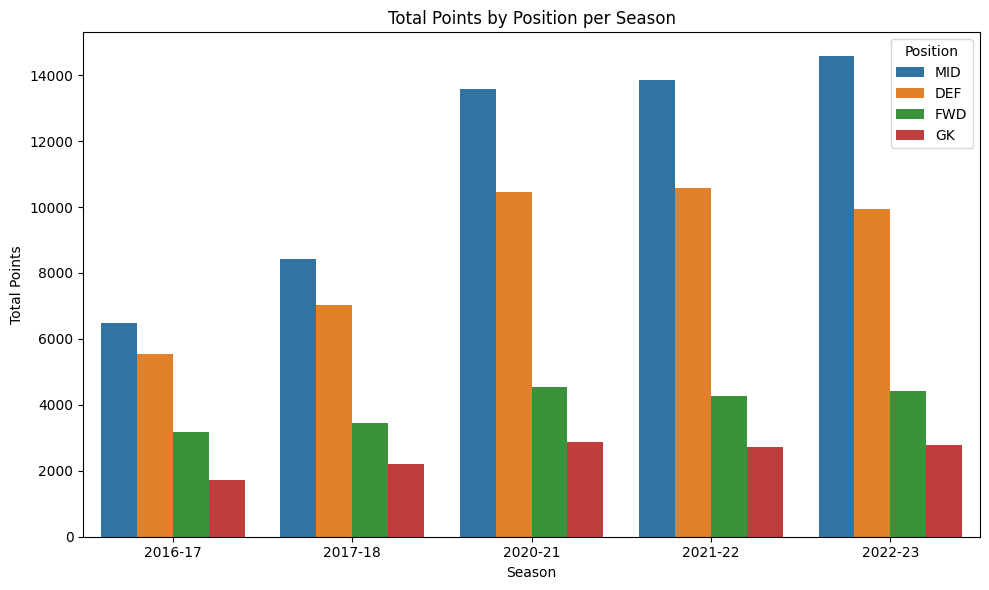

In [101]:
df_plot = (
    df_with_form_temp
    .groupby(['season_x', 'position'], as_index=False)['total_points']
    .sum()
    .sort_values(['season_x', 'total_points'], ascending=[True, False])
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_plot,
    x='season_x',
    y='total_points',
    hue='position'
)
plt.title('Total Points by Position per Season')
plt.xlabel('Season')
plt.ylabel('Total Points')
plt.legend(title='Position')
plt.tight_layout()
plt.show()


So it looks like It's always MID then DEF then FWD then finally GK but let's compute it to be sure.

Looks like we were correct to assume that.

  position  total_points
3      MID       11384.4
0      DEF        8705.2
1      FWD        3975.8
2       GK        2463.2


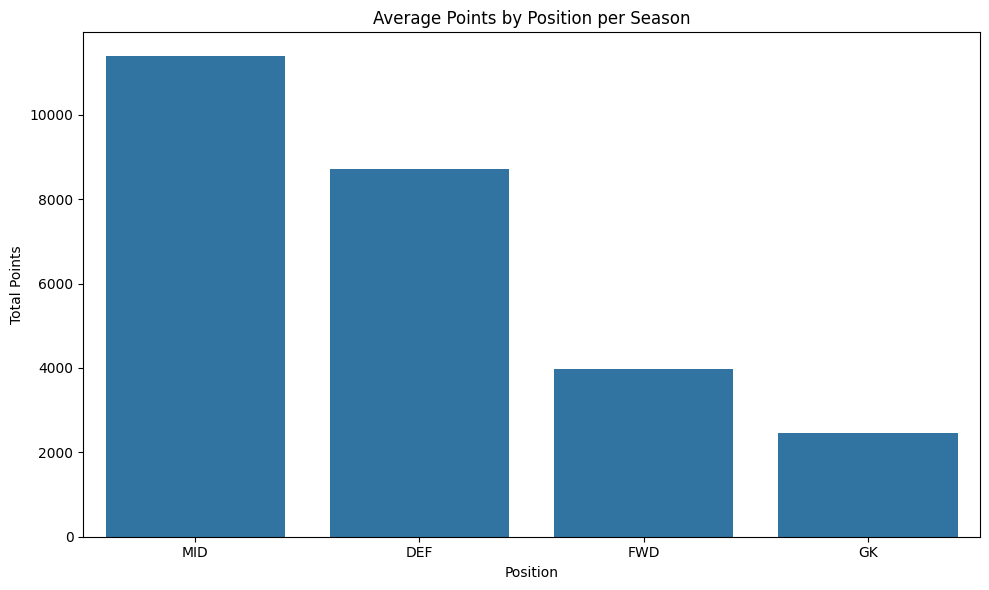

In [93]:
avg_df = (
    df_plot
    .groupby('position', as_index=False)['total_points']
    .mean()
    .sort_values(['total_points'], ascending=False)
)

print(avg_df)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_df,
    x='position',
    y='total_points',
)
plt.title('Average Points by Position per Season')
plt.xlabel('Position')
plt.ylabel('Total Points')
plt.tight_layout()
plt.show()

Let's now look at how the form of the top 5 players evolved during the 22/23 Season.

Let's filter by season to get the 22-23 Season.

In [94]:
season_df = df_with_form_temp[df_with_form_temp['season_x'] == '2022-23']


Let's now identify the top 5 Players -> Let's say that the top 5 players are the top 5 players according to total_points

In [95]:
top5_players = (
    season_df.groupby('name', as_index=False)['total_points']
    .sum()
    .sort_values('total_points', ascending=False)
    .head(5)
)

print(top5_players)

                name  total_points
210   Erling Haaland           272
256       Harry Kane           263
540    Mohamed Salah           239
498  Martin Ødegaard           212
490  Marcus Rashford           205


Kinda Expected to see Haaland there haha, let's continue with the analysis

Let's track the form over the Gameweek

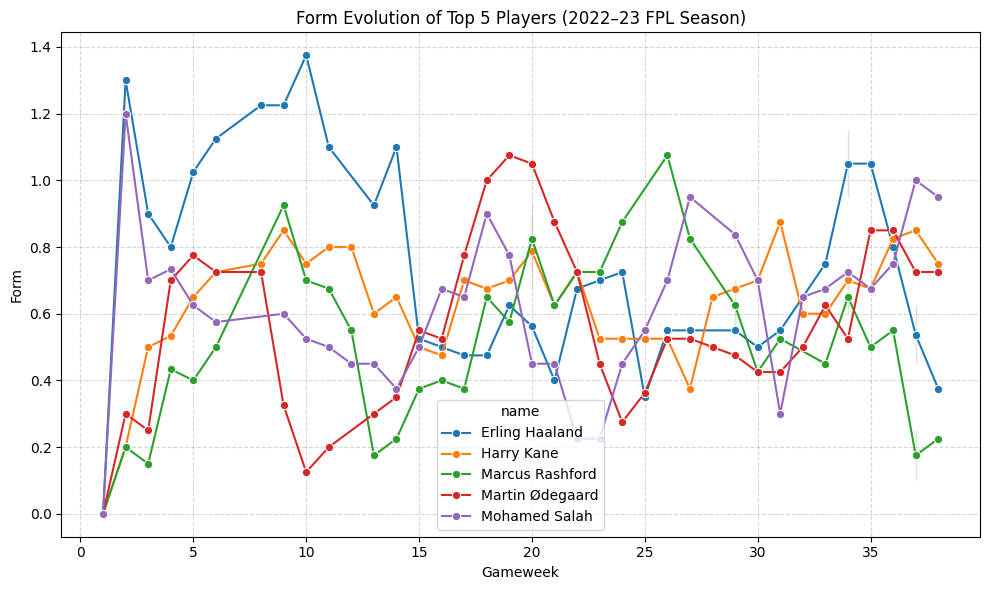

In [96]:
top5_form_df = season_df[season_df['name'].isin(top5_players['name'])]

plt.figure(figsize=(10,6))
sns.lineplot(
    data=top5_form_df,
    x='round',
    y='form',
    hue='name',
    marker='o'
)
plt.title('Form Evolution of Top 5 Players (2022–23 FPL Season)')
plt.xlabel('Gameweek')
plt.ylabel('Form')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Looks interesting, lots of fluctuations there, looks like the most consistent was Harry Kane

Let's now compute the average form per player and get the top 5 players with highest form.

In [100]:
avg_form = (
    season_df.groupby('name', as_index=False)['form']
    .mean()
    .sort_values('form', ascending=False)
)

print(avg_form.head(5))

                         name      form
210            Erling Haaland  0.742763
256                Harry Kane  0.635746
540             Mohamed Salah  0.621272
498           Martin Ødegaard  0.550658
236  Gabriel Martinelli Silva  0.546930


This shows that Players who had the highest total_points are usually the most in form.

Let's start our Data Cleaning and Feature Engineering

We start our data cleaning process by dropping unused or redundant columns. For example, 'GW' is the same as round so we drop it and we drop team_a_score and team_h_score as we used them to feature engineer above.

In [52]:
cols_to_drop = [
    "selected", "transfers_in", "transfers_out",
    "transfers_balance", "GW", 'element',
    'fixture', 'kickoff_time', 'opponent_team', 'team_a_score',
    'team_h_score', 'influence', 'opp_team_name', 'own_goals', 'creativity',
    'threat', 'team_x'
]

df_cleaned = drop_columns_save_interim(df, cols_to_drop)

Cleaned file saved to: /Users/youssefmalek/PycharmProjects/data/interim/dataset_post_drop.csv


We then normalize the position column to transform values from 'GKP' to 'GK' as both refer to the same thing.

In [53]:
df_cleaned = normalize_position_column(df_cleaned)

We encode the name column as machine learning models don't understand strings rather numbers and it is a categorical feature.

In [54]:
df_label_encoded, le_name = label_encode_column(df_cleaned, column="name")

Column 'name' label-encoded → new column 'name_encoded'


We one-hot encode our now normalized position column as it is a categorical feature and we wouldn't want the model to think that MidLaner is better than Goalkeeper if we LabelEncode and set DropFirst to true.

In [55]:
cols_to_one_hot_encode = [
    "position",
]

df_one_hot_encoded = one_hot_encode_columns(df_label_encoded, cols_to_one_hot_encode)

We map these columns from True/False to 1/0.

In [56]:
cols_to_map_to_int = [
    'was_home', 'position_FWD', 'position_MID', 'position_GK',
]

df_mapped = map_bool_to_int(df_one_hot_encoded, cols_to_map_to_int)

We add the form column.

In [57]:
df_with_form = add_form(df_mapped)

Form-added file saved to: /Users/youssefmalek/PycharmProjects/data/interim/dataset.csv


We add new features for each of these columns called lagged features. Meaning that during prediction the model can have information for the performance of a player during Game weeks before the current.

In [58]:
cols_to_add_lag = [
    'assists', 'bonus', 'bps', 'clean_sheets',
    'goals_conceded', 'goals_scored', 'ict_index',
    'minutes', 'saves', 'yellow_cards', 'ally_goals', 'opponent_goals',
]

df_with_lagged_features = add_lag_features(df_with_form, cols_to_add_lag)

We print the Columns in our cleaned dataset.

In [59]:
print(f"Number of Columns in our cleaned dataset: {df_with_lagged_features.columns.value_counts().count()}")
print(df_with_lagged_features.columns)

Number of Columns in our cleaned dataset: 49
Index(['season_x', 'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
       'goals_scored', 'ict_index', 'minutes', 'penalties_missed',
       'penalties_saved', 'red_cards', 'round', 'saves', 'total_points',
       'value', 'was_home', 'yellow_cards', 'ally_goals', 'opponent_goals',
       'name_encoded', 'position_FWD', 'position_GK', 'position_MID', 'form',
       'assists_lag1', 'assists_lag2', 'bonus_lag1', 'bonus_lag2', 'bps_lag1',
       'bps_lag2', 'clean_sheets_lag1', 'clean_sheets_lag2',
       'goals_conceded_lag1', 'goals_conceded_lag2', 'goals_scored_lag1',
       'goals_scored_lag2', 'ict_index_lag1', 'ict_index_lag2', 'minutes_lag1',
       'minutes_lag2', 'saves_lag1', 'saves_lag2', 'yellow_cards_lag1',
       'yellow_cards_lag2', 'ally_goals_lag1', 'ally_goals_lag2',
       'opponent_goals_lag1', 'opponent_goals_lag2'],
      dtype='object')


Now we add our target feature, our Y, which is what we are trying to predict. It is just total_points shifted upwards by 1 and we drop total_points to stop model peeking!


In [60]:
df_with_target = add_upcoming_total_points(df_with_lagged_features)

X, y = build_xy(df_with_target, keep_player_id=True, player_col="name_encoded")

X = X.drop(columns=['total_points'])

We split the data into 3 sets - Train, Validation and Test and we split by season so for example in our data there are 5 seasons, we split the data into Training: 3 Seasons Validation: 1 Season, Test: 1 Season to respect the temporal flow.

We note in our report the performance of the model if we follow a naive 80:10:10 split.

In [61]:
train_idx, valid_idx, test_idx, years_sorted = auto_global_temporal_split_inseason(
    df_with_target,
    season_col="season_x",
    week_col="round",
    train_frac=0.8, valid_frac=0.1, test_frac=0.1,
    split_train_valid=True, ratio_train_valid=0.8,
    split_valid_test=True, ratio_valid_test=0.5,
)

_ = summarize_round_splits(
    df=df_with_target,
    train_idx=train_idx,
    valid_idx=valid_idx,
    test_idx=test_idx,
    season_col="season_x",
    week_col="round",
)

X_train, y_train = X.loc[train_idx].copy(), y.loc[train_idx].copy()
X_valid, y_valid = X.loc[valid_idx].copy(), y.loc[valid_idx].copy()
X_test, y_test = X.loc[test_idx].copy(), y.loc[test_idx].copy()


Round allocation by season (min–max rounds per subset):
  2016-17: TRAIN 1–37 (37) | VALID — (0) | TEST — (0) | order_ok=True
  2017-18: TRAIN 1–37 (37) | VALID — (0) | TEST — (0) | order_ok=True
  2020-21: TRAIN 1–38 (38) | VALID — (0) | TEST — (0) | order_ok=True
  2021-22: TRAIN 1–30 (30) | VALID 31–38 (8) | TEST — (0) | order_ok=True
  2022-23: TRAIN — (0) | VALID 1–19 (18) | TEST 20–38 (19) | order_ok=True


Let's drop the name column as we won't use it in the rest of our pipeline only for checking performance on seen players vs non-seen players during training - the Cold Start Problem

In [62]:
train_names = X_train["name_encoded"].copy()
test_names = X_test["name_encoded"].copy()

X_train = X_train.drop(columns=["name_encoded"], errors="ignore")
X_valid = X_valid.drop(columns=["name_encoded"], errors="ignore")
X_test = X_test.drop(columns=["name_encoded"], errors="ignore")

In [63]:
print(f"Seasons by start year (chronological): {years_sorted}")
print(f"Train rows: {len(X_train)}, Valid rows: {len(X_valid)}, Test rows: {len(X_test)}")

Seasons by start year (chronological): [2016, 2017, 2020, 2021, 2022]
Train rows: 61684, Valid rows: 17251, Test rows: 14452


Let's train a FFNN on our Data and evaluate it.

We use early stopping to avoid training without validation MAE improvement and we output our metrics for R2, RMSE, MSE and MAE

In [64]:
model_ffnn = train_ffnn(X_train, y_train, X_valid, y_valid)
evaluate_model(model_ffnn, X_test, y_test, X_train, y_train, X_valid, y_valid)


📊 Evaluation Metrics:
  TRAIN:  MAE=1.2669  RMSE=2.2027  R2=0.2954
  VALID:  MAE=1.0975  RMSE=2.0475  R2=0.2938
  TEST:  MAE=0.9819  RMSE=1.9034  R2=0.3035


{'train': {'MAE': 1.2668677149875593,
  'MSE': 4.851677338091797,
  'RMSE': 2.2026523416308343,
  'R2': 0.29537509566171427},
 'valid': {'MAE': 1.097534634580839,
  'MSE': 4.192109439402254,
  'RMSE': 2.0474641485023013,
  'R2': 0.29384244671956894},
 'test': {'MAE': 0.9819226422422654,
  'MSE': 3.62298812372517,
  'RMSE': 1.903414858543762,
  'R2': 0.30349618106008347}}

We also report on the metrics of seen players vs unseen players in the test dataset.

In [65]:
seen_players = set(train_names.unique())
test_seen_mask = test_names.isin(seen_players)
test_cold_mask = ~test_seen_mask

print("\n Test composition:")
print(f"  Seen players rows:      {int(test_seen_mask.sum())}")
print(f"  Cold-start players rows: {int(test_cold_mask.sum())}")

def eval_subset(model, X_te, y_te, mask, label: str):
    n = int(mask.sum())
    if n == 0:
        print(f"{label}: no rows.")
        return

    metrics = evaluate_model(model, X_te[mask], y_te[mask])
    print(f"{label}: n={n} | {metrics}")

print("\nFFNN — Seen vs Cold-start:")
eval_subset(model_ffnn, X_test, y_test, test_seen_mask, "TEST (seen players)")
eval_subset(model_ffnn, X_test, y_test, test_cold_mask, "TEST (cold-start players)")


 Test composition:
  Seen players rows:      8687
  Cold-start players rows: 5765

FFNN — Seen vs Cold-start:

📊 Evaluation Metrics:
  TEST:  MAE=1.0799  RMSE=2.0177  R2=0.2937
TEST (seen players): n=8687 | {'test': {'MAE': 1.0799265269053275, 'MSE': 4.071019423291186, 'RMSE': 2.017676739046963, 'R2': 0.29370531984151094}}

📊 Evaluation Metrics:
  TEST:  MAE=0.8342  RMSE=1.7169  R2=0.3141
TEST (cold-start players): n=5765 | {'test': {'MAE': 0.8342453229031869, 'MSE': 2.9478714022766868, 'RMSE': 1.716936633157056, 'R2': 0.31414547554837813}}
